<a href="https://colab.research.google.com/github/catastropiyush/Papers-in-100-Lines-of-Code/blob/main/Adversarial_Feature_Learning/Untitled43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 187500/187500 [20:57<00:00, 149.09it/s]


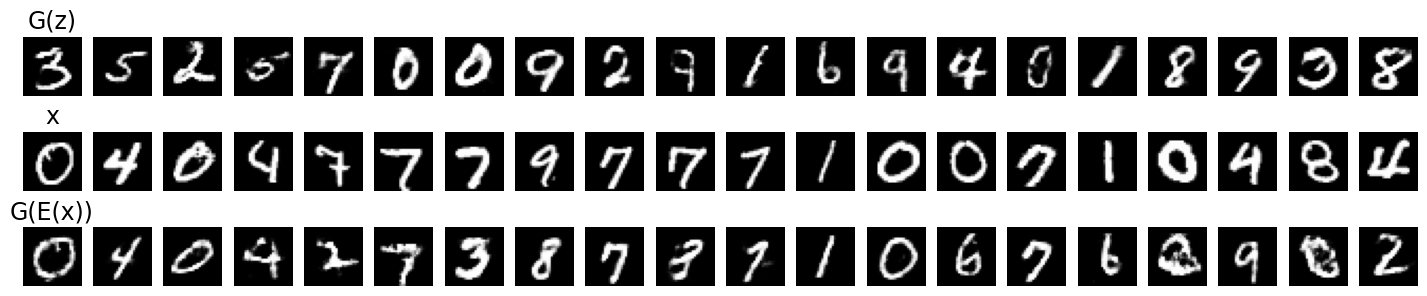

In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.datasets.mnist import load_data

# load (and normalize) mnist dataset
(trainX, trainy), (testX, testy) = load_data()
trainX = np.float32(trainX) / 255.


def sample_latent(batch_size, device):
    return torch.rand((batch_size, 50), device=device)


def get_minibatch(batch_size, device):
    indices = torch.randperm(trainX.shape[0])[:batch_size]
    return torch.tensor(trainX[indices], dtype=torch.float).reshape(batch_size, -1).to(device)


class G(nn.Module):

    def __init__(self):
        super(G, self).__init__()
        self.network = nn.Sequential(nn.Linear(50, 1024), nn.ReLU(),
                                     nn.Linear(1024, 1024), nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False),
                                     nn.ReLU(), nn.Linear(1024, 784), nn.Sigmoid())

    def forward(self, x):
        return self.network(x)


class E(nn.Module):

    def __init__(self):
        super(E, self).__init__()
        self.network = nn.Sequential(nn.Linear(784, 1024), nn.LeakyReLU(0.2),
                                     nn.Linear(1024, 1024), nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False),
                                     nn.LeakyReLU(0.2), nn.Linear(1024, 50), nn.Sigmoid())

    def forward(self, x):
        return self.network(x)


class D(nn.Module):

    def __init__(self):
        super(D, self).__init__()
        self.network = nn.Sequential(nn.Linear(784 + 50, 1024), nn.LeakyReLU(0.2),
                                     nn.Linear(1024, 1024), nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False),
                                     nn.LeakyReLU(0.2), nn.Linear(1024, 1), nn.Sigmoid())

    def forward(self, x, z):
        return self.network(torch.cat((z, x), dim=1))


def train(D, G, E, optimizers, schedulers, batch_size=128, device='cpu', nb_epochs=187500):
    for epoch in tqdm(range(nb_epochs)):
        z = sample_latent(batch_size, device=device)
        x = get_minibatch(batch_size, device=device)

        lambda_objective = torch.nn.BCELoss()(D(G(z), z).reshape(batch_size), torch.ones(batch_size, device=device)) + \
                           torch.nn.BCELoss()(D(x, E(x)).reshape(batch_size), torch.zeros(batch_size, device=device))

        for optimizer in optimizers:
            optimizer.zero_grad()
        lambda_objective.backward()
        for optimizer in optimizers:
            optimizer.step()

        if epoch > (nb_epochs / 2):
            for scheduler in schedulers:
                scheduler.step()


if __name__ == "__main__":
    device = 'cuda'

    g = G().to(device)
    e = E().to(device)
    d = D().to(device)

    optimizers = [torch.optim.Adam(g.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5, maximize=True),
                  torch.optim.Adam(e.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5, maximize=True),
                  torch.optim.Adam(d.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5, maximize=False)]

    schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999508793911394) for optimizer in optimizers]

    train(d, g, e, optimizers, schedulers, device=device)

    z = sample_latent(20, device=device)
    gz = g(z)
    x = get_minibatch(20, device=device)
    z = e(x)
    x_hat = g(z)
    plt.figure(figsize=(18, 3.5))
    for i in range(20):
        plt.subplot(3, 20, 1 + i)
        plt.axis('off')
        if i == 0:
            plt.title('G(z)', fontsize=17)
        plt.imshow(gz[i].data.cpu().numpy().reshape(28, 28), cmap='gray')
        plt.subplot(3, 20, 21 + i)
        plt.axis('off')
        if i == 0:
            plt.title('x', fontsize=17)
        plt.imshow(x[i].data.cpu().numpy().reshape(28, 28), cmap='gray')
        plt.subplot(3, 20, 41 + i)
        plt.axis('off')
        plt.imshow(x_hat[i].data.cpu().numpy().reshape(28, 28), cmap='gray')
        if i == 0:
            plt.title('G(E(x))', fontsize=17)
    plt.savefig("adversarial_feature_learning.png")